<a href="https://colab.research.google.com/github/LeandroMAcosta/clustering_nlp/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U spacy==3.1.2
!python -m spacy download es_core_news_md
!python -m spacy download es_core_news_lg

     |████████████████████████████████| 42.7 MB 52 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
     |████████████████████████████████| 568.4 MB 13 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')


In [2]:
import spacy
import pickle
import matplotlib.pyplot as plt
from nltk.cluster.kmeans import KMeansClusterer
from nltk.cluster import cosine_distance
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
import random

In [16]:
# Settings
ROOTCORPUS = "./corpus/"
file_name = "lavoztextodump.txt"
# MAX_LINES = 30000
MAX_LINES = 700000
NUMBER_OF_CLUSTERS = 6
NUMBER_OF_ITERATIONS = 600
THRESHOLD_WORD = 30
THRESHOLD_CONTEXT = 10
THRESHOLD_VECTOR = 0.001
CONTEXT_SIZE = 2
ignored_words = ["el", "él", "que", "de", "en"]

In [17]:
filename_path = ROOTCORPUS + file_name
text_file = open(filename_path, "r")
corpus = text_file.read()
text_file.close()
nlp = spacy.load("es_core_news_lg")
doc = nlp(corpus[:MAX_LINES])

In [28]:
sents = [sent for sent in doc.sents if len(sent) > 5]

words = []
words_lemma = []
for sent in sents:
    for word in sent:
        if word.is_alpha and word.lemma_ not in ignored_words and len(word.lemma_) > 1:
            words.append(word)
            words_lemma.append(word.lemma_)
            
counts_lemma = Counter(words_lemma)

In [47]:
def build_features(words, counts_lemma):
    features = defaultdict(lambda:defaultdict(int))
    for i, word in enumerate(words):
        lemma_str = word.lemma_
        if counts_lemma[lemma_str] < THRESHOLD_WORD or word.like_num:
            continue
        
        pos = "POS__" + word.pos_  
        features[lemma_str][pos] += 1 
        
        dep = "DEP__" + word.dep_
        features[lemma_str][dep] += 1
        
        features[lemma_str]['pos'] = word.pos_
        features[lemma_str]['lemma'] = word.lemma_                        
        features[lemma_str]['is_lower'] = word.is_lower

        context_left = words[max(i - CONTEXT_SIZE, 0): i] 
        context_right = words[i + 1 : min(len(words), i+1+CONTEXT_SIZE)]
        context = context_left + context_right
        for c_word in context:       
            c_lemma = c_word.lemma_ 
            if c_word.is_alpha and counts_lemma[c_lemma] > THRESHOLD_CONTEXT: 
                if c_word.like_num: 
                    features[lemma_str]["NUM__" + c_lemma] += 1
                else:
                    features[lemma_str][c_lemma] += 1
    
    keys = list(features.keys())
    features_arr = [dict(features[key]) for key in keys]
    
    return keys, features_arr


In [48]:
def vectorizer(features):
    v = DictVectorizer(sparse=False)
    vectors_matrix = v.fit_transform(features)
    return vectors_matrix

def normalize_matrix(vectors_matrix):
    normalized_matrix = vectors_matrix / vectors_matrix.max(axis=0)
    variances = np.square(normalized_matrix).mean(axis=0) - np.square(normalized_matrix.mean(axis=0))
    normalized_matrix = np.delete(normalized_matrix, np.where(variances < THRESHOLD_VECTOR), axis=1)
    return normalized_matrix

def dimension_reduction(vectors_matrix):
    pca = PCA(n_components=2)
    vectors_matrix_2d = pca.fit_transform(vectors_matrix)
    return vectors_matrix_2d

def clustering(vectors):
    kmeans = KMeans(n_clusters=NUMBER_OF_CLUSTERS, max_iter=NUMBER_OF_ITERATIONS, random_state=100)
    kmeans.fit(vectors)
    v_labels = kmeans.predict(vectors)
    return kmeans, v_labels

def clustering_2(k, vectors):
    clusterer = KMeansClusterer(k, cosine_distance, avoid_empty_clusters=True)
    clusters = clusterer.cluster(vectors, True)
    return clusters

In [49]:
print("Words: ", words)
keys, features = build_features(words, counts_lemma)
print("Keys: ", keys)
print("Features: ", features)

Words:  [sostiene, pareja, es, amor, Clara, Crespo, Rodolfo, Martínez, no, imaginan, uno, sin, otro, Prefiero, ni, pensarlo, dice, Clara, Hace, años, están, casados, tienen, cuatro, hijas, mujeres, conocieron, Ateneo, Juventus, movimiento, juvenil, Capuchinos, Hoy, aseguran, no, estar, sorprendidos, del, tiempo, llevan, juntos, sino, haber, logrado, entenderse, tan, bien, gusta, disgusta, del, otro, Me, gusta, sea, cariñosa, alegre, esté, siempre, pensando, mí, es, una, gran, madre, Me, disgustaba, cuando, enojaba, no, quería, hablar, pero, ya, no, hace, más, veces, es, indecisa, pero, ya, me, acostumbré, No, quiero, cambiarle, nada, sea, como, es, Me, gusta, es, una, persona, emprendedora, alegre, optimista, servicial, Me, gustaría, veces, fuera, más, sutil, para, decir, cosas, Pienso, personas, vamos, cambiando, con, tiempo, acuerdo, edad, circunstancias, vivimos, todo, nos, rodea, Seguramente, no, somos, mismos, cuando, nos, casamos, siempre, seguiremos, descubriendo, cosas, nuevas,

In [50]:
print(counts_lemma)

Counter({'uno': 2370, 'ser': 1784, 'del': 1406, 'por': 1346, 'con': 1036, 'no': 1021, 'para': 996, 'su': 800, 'haber': 735, 'al': 699, 'estar': 530, 'este': 521, 'tener': 489, 'más': 471, 'como': 394, 'poder': 389, 'ese': 386, 'año': 355, 'pero': 334, 'Córdoba': 331, 'otro': 321, 'todo': 314, 'decir': 286, 'hacer': 281, 'yo': 245, 'desde': 243, 'entre': 230, 'ciento': 229, 'si': 216, 'mucho': 209, 'ya': 203, 'primero': 199, 'también': 198, 'hasta': 193, 'cuando': 189, 'dos': 183, 'día': 182, 'alguno': 169, 'ir': 168, 'sobre': 168, 'millón': 168, 'ayer': 157, 'quien': 156, 'sin': 153, 'deber': 150, 'sólo': 144, 'país': 139, 'dar': 136, 'porque': 132, 'empresa': 128, 'presidente': 123, 'provincial': 123, 'vez': 122, 'nuevo': 119, 'último': 119, 'político': 119, 'mil': 118, 'gobernador': 118, 'mismo': 117, 'Gobierno': 117, 'hoy': 113, 'llegar': 113, 'pasar': 110, 'según': 110, 'tanto': 109, 'ahora': 109, 'mes': 109, 'caso': 109, 'ver': 108, 'realizar': 107, 'donde': 106, 'parte': 106, 'qu

In [51]:
vectors_matrix = vectorizer(features)
normalized_matrix = normalize_matrix(vectors_matrix)
vectors_matrix_2d = dimension_reduction(normalized_matrix)

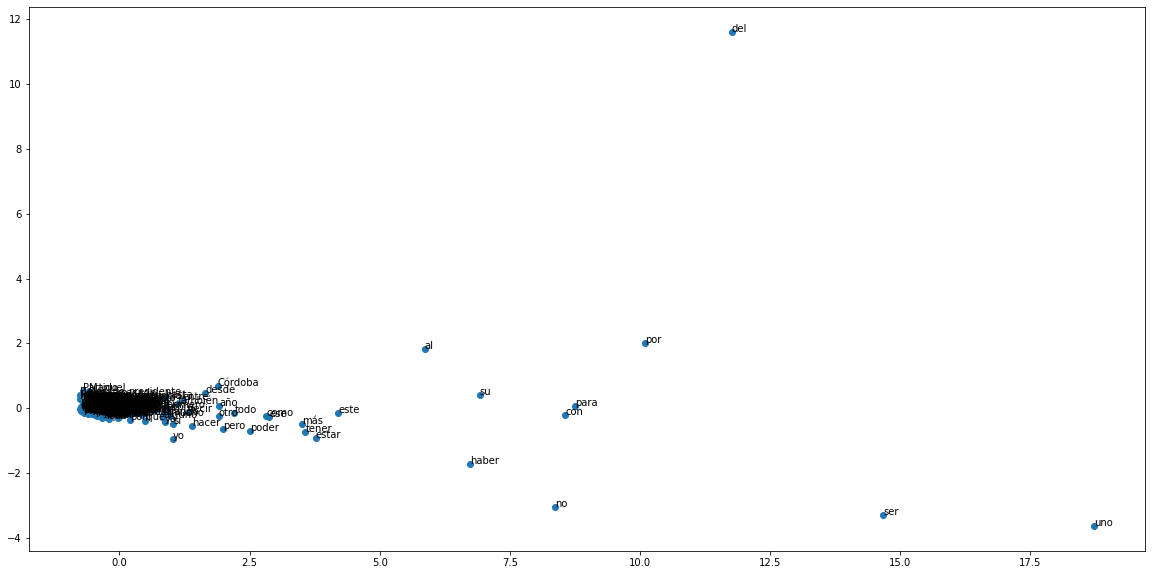

In [52]:
x_axis = [point[0] for point in vectors_matrix_2d]
y_axis = [point[1] for point in vectors_matrix_2d]

fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(x_axis, y_axis)

for i, key in enumerate(keys):
    ax.annotate(key, (x_axis[i], y_axis[i]))

In [53]:
# kmeans, v_labels = clustering(vectors_matrix)
v_labels = clustering_2(10, vectors_matrix_2d)


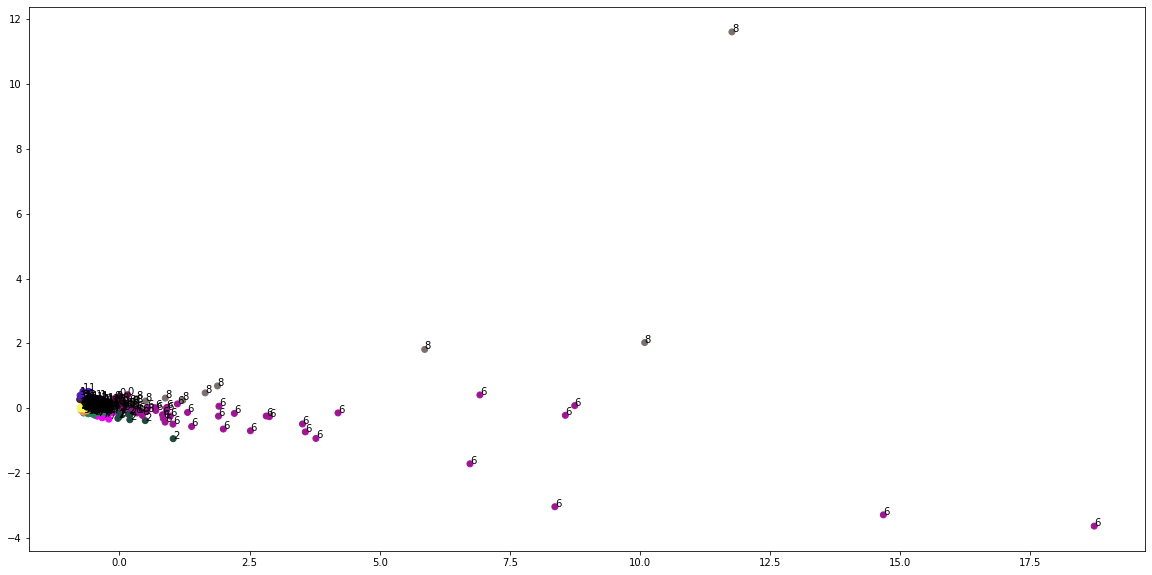

In [54]:
set_labels = set(v_labels)
colors = defaultdict(int)
for label in set_labels:
    colors[label] = "#" + "".join([random.choice('0123456789ABCDEF') for _ in range(6)])

x_axis = [point[0] for point in vectors_matrix_2d]
y_axis = [point[1] for point in vectors_matrix_2d]

fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(x_axis, y_axis, c=[colors[label] for label in v_labels])

clusters = defaultdict(list)
for i, label in enumerate(v_labels):
    clusters[label].append(keys[i])
    ax.annotate(label, (x_axis[i], y_axis[i]))

Estoy clusterizando mal, creo que es por algun preprocesamiento mal hecho

In [55]:
print(clusters[3])

['después', 'Ministerio', 'venir', 'noche', 'Daniel', 'De', 'jefe', 'mayor', 'zona', 'ruta', 'indicar', 'Nacional', 'Carlos', 'Río', 'fin', 'legislador', 'Pablo', 'General', 'mientras', 'principal', 'Unión', 'argentino', 'interno', 'alto', 'especial', 'local', 'hacia', 'electoral', 'Buenos', 'Aires', 'partido', 'senador', 'Federal', 'frente', 'Sota', 'brasileño', 'cuyo', 'Dilma', 'Rousseff', 'Lula', 'Chile', 'fiscal', 'Ecuador', 'Correa', 'vuelo']
